## Domaci zadatak iz prepoznavanja oblika

### Zadatak 1. Opcija 2.

### Uvoz neophodnih biblioteka

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage import util
from skimage import color

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Predprocesiranje slika

Funkcija crop_hand sece sliku tako da izdvoji samo saku na slici

In [2]:
def crop_hand(img):
    
    #Sliku posmatramo u HSV prostoru da bi izdvojili zelenu pozadinu
    img_hsv = color.rgb2hsv(img)
    img_shape = img.shape
    M = img_shape[0]
    N = img_shape[1]

    #Zelimo pocetne i krajnje koordinate ruke da bi isekli samo korisni deo slike
    m_pocetno = 0
    n_pocetno = 0
    m_krajnje = M-1
    n_krajnje = N-1
    
    #Pocetna i krajnja vrsta
    for i in range(M):
        for j in range(N):
            if m_pocetno == 0:
                if img_hsv[i,j,1] > 0.2 and img_hsv[i,j,2] > 0.2:
                    if img_hsv[i,j,0] < 0.14 or img_hsv[i,j,0] > 0.46:
                        m_pocetno = i
            if m_krajnje == M-1:
                if img_hsv[M-i-1,N-j-1,1] > 0.2 and img_hsv[M-i-1,N-j-1,2] > 0.2:
                    if img_hsv[M-i-1,N-j-1,0] < 0.14 or img_hsv[M-i-1,N-j-1,0] > 0.46:
                        m_krajnje = M-i-1
                    
        if m_pocetno != 0 and m_krajnje != M-1:
            break
    #Pocetna i krajnja kolona
    for j in range(N):
        for i in range(M):
            if n_pocetno == 0:
                if img_hsv[i,j,1] > 0.2 and img_hsv[i,j,2] > 0.2:
                    if img_hsv[i,j,0] < 0.14 or img_hsv[i,j,0] > 0.46:
                        n_pocetno = j
            if n_krajnje == N-1:
                if img_hsv[M-i-1,N-j-1,1] > 0.2 and img_hsv[M-i-1,N-j-1,2] > 0.2:
                    if img_hsv[M-i-1,N-j-1,0] < 0.14 or img_hsv[M-i-1,N-j-1,0] > 0.46:
                        n_krajnje = N-j-1
                    
        if n_pocetno != 0 and n_krajnje != N-1:
            break

    #Secemo sliku
    img_cropped = img[m_pocetno:m_krajnje,n_pocetno:n_krajnje]
    
    return img_cropped

### Izdvajanje obelezja

Funkcija features vraca odnos ne-zelenih piksela na levoj i desnoj polovini slike i odnos duzine i sirine slike:

In [3]:
def features(img_cropped):

    img_hsv = color.rgb2hsv(img_cropped)

    img_shape = img_cropped.shape

    M = img_shape[0]
    N = img_shape[1]

    #Stavljamo pocetne vrendosti na 1, nece mnogo uticati na odnos a za svaki slucaj da ne bude deljenje sa 0 nigde
    saka_levo = 1
    saka_desno = 1
    for i in range(M):
        for j in range(N):
        #Zelimo odnos broja piksela koji su saka levo i desno
            if img_hsv[i,j,1] > 0.2 and img_hsv[i,j,2] > 0.2:
                if img_hsv[i,j,0] < 0.14 or img_hsv[i,j,0] > 0.46:
                    if j < round(N*0.5):
                        saka_levo = saka_levo + 1
                    else:
                        saka_desno = saka_desno + 1
                        
    return [saka_levo/saka_desno, N/M]


Testiranje funkcija crop_hand i features na primeru:

Prvo obelezje: 0.6477764659582841 , Drugo obelezje: 1.7067669172932332


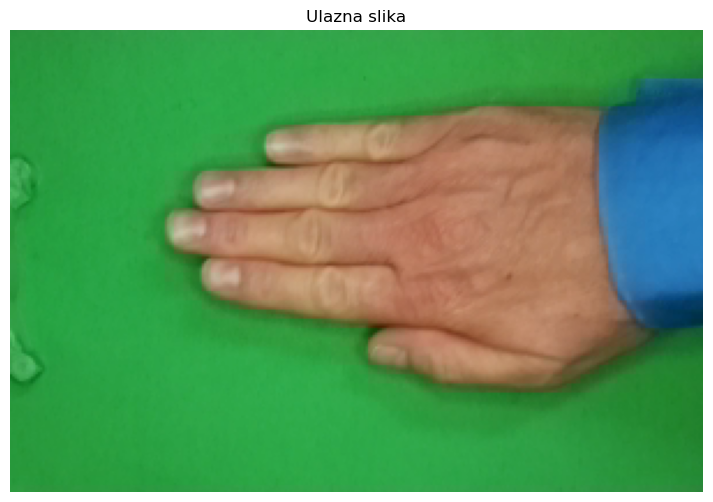

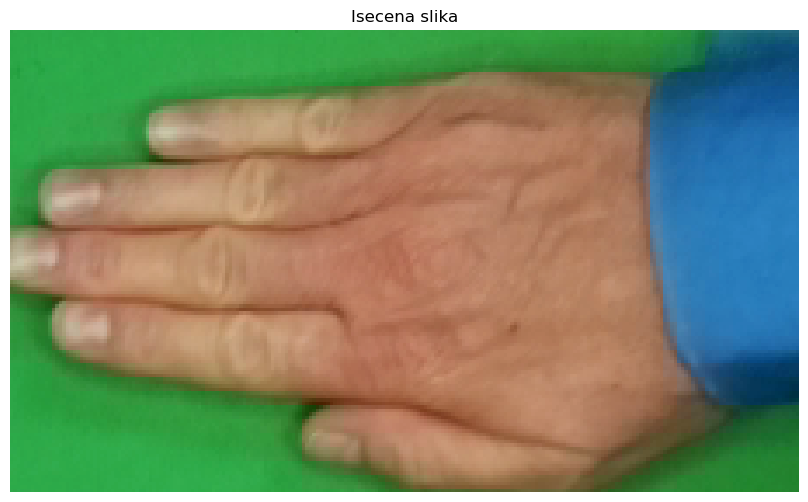

In [4]:
img = util.img_as_float(io.imread('paper/389udM70tLrMVL5H.png'))

fix, axes = plt.subplots(1, 1, figsize=(15, 6))
axes.imshow(img)
axes.set_title('Ulazna slika')
axes.axis('off')

img_cropped = crop_hand(img)

fix, axes = plt.subplots(1, 1, figsize=(15, 6))
axes.imshow(img_cropped)
axes.set_title('Isecena slika')
axes.axis('off')

img_features = features(img_cropped)
print("Prvo obelezje:",img_features[0],", Drugo obelezje:", img_features[1])

### Primena predprocesiranja i izdvajanja obelezja na svaku sliku iz baze podataka

In [5]:
#Primena predprocesiranja i izdvajanja obelezja nad svim slikama
folder_paper = 'paper'
folder_rock = 'rock'
folder_scissors = 'scissors'

paper = []
rock = []
scissors = []

#i = 0
for filename in os.listdir(folder_paper):
    image_path = os.path.join(folder_paper, filename)
    img = util.img_as_float(io.imread(image_path))
    img_cropped = crop_hand(img)
    paper.append(features(img_cropped))
    #i = i + 1
    
i = 0
for filename in os.listdir(folder_rock):
    image_path = os.path.join(folder_rock, filename)
    img = util.img_as_float(io.imread(image_path))
    img_cropped = crop_hand(img)
    rock.append(features(img_cropped))
    i = i + 1
    
i = 0
for filename in os.listdir(folder_scissors):
    image_path = os.path.join(folder_scissors, filename)
    img = util.img_as_float(io.imread(image_path))
    img_cropped = crop_hand(img)
    scissors.append(features(img_cropped))
    i = i + 1


In [6]:
#Izuzimanje outliera
paper = np.array(paper)
rock = np.array(rock)
scissors = np.array(scissors)

paper_real = []
rock_real = []
scissors_real = []

for i in range(len(rock)):
    if rock[i,0] < 2 and rock[i,1] < 4:
        rock_real.append([rock[i,0], rock[i,1]])

for i in range(len(paper)):
    if paper[i,0] < 2 and paper[i,1] < 4:
        paper_real.append([paper[i,0], paper[i,1]])
        
for i in range(len(scissors)):
    if scissors[i,0] < 2 and scissors[i,1] < 4:
        scissors_real.append([scissors[i,0], scissors[i,1]])
        
paper = np.array(paper_real)
scissors = np.array(scissors_real)
rock = np.array(rock_real)

### Podela baze na trening i test skup

In [7]:
#Delimo na trening i test skup
X_train, X_test, Y_train, Y_test = train_test_split(data, y, test_size = 0.2, stratify=y, random_state=20)

#Formiramo klase 0,1 i 2
#0 -> paper
#1 -> rock
#2 -> scissors
paper_train = X_train[Y_train.ravel() == 0]
rock_train = X_train[Y_train.ravel() == 1]
scissors_train = X_train[Y_train.ravel() == 2]

NameError: name 'data' is not defined

### Vizuelizacija u prostoru obelezja

In [ ]:
plt.figure()
plt.xlabel('Obeležje 1 - odnos ne-zelenih piksela levo/desno'); 
plt.ylabel('Obeležje 2 - odnos N/M')
plt.title('Papir kamen makaze u prostoru obelezja')
plt.plot(paper_train[:,0],paper_train[:,1],'rx')
plt.plot(rock_train[:,0],rock_train[:,1],'gx')
plt.plot(scissors_train[:,0],scissors_train[:,1], 'bx')
plt.legend(['Papir','Kamen', 'Makaze'])

### Klasifikacija - test vise hipoteza

In [ ]:
#Visedimenzionalna Gausova raspodela
def gaussian_pdf(X, M, S):
    detS = np.linalg.det(S)
    invS = np.linalg.inv(S)
    f = 1/(2*np.pi*detS**0.5)*np.exp(-0.5*(X-M).T@invS@(X-M))
    return f  

#Matematicko ocekivanje
M1 = np.mean(paper_train, axis=0)
M2 = np.mean(rock_train, axis=0)
M3 = np.mean(scissors_train, axis=0)

#Kovarijaciona matrica
S1 = np.cov(paper_train.T)
S2 = np.cov(rock_train.T)
S3 = np.cov(scissors_train.T)

#Verovatnoca pojavljivanja klasa
p1 = len(paper_train)/(len(paper_train)+len(rock_train)+len(scissors_train))
p2 = len(rock_train)/(len(paper_train)+len(rock_train)+len(scissors_train))
p3 = 1 - p1 - p2

result_predicted = np.zeros((len(Y_test),1))

#Klasifikacija na test skupu
for i in range(len(X_test)):
    data_i = X_test[i]
    f1 = gaussian_pdf(data_i, M1, S1)
    f2 = gaussian_pdf(data_i, M2, S2)
    f3 = gaussian_pdf(data_i, M3, S3)
    f = [p1*f1, p2*f2, p3*f3]
    result_predicted[i] = np.argmax(f)


### Rezultat klasfikacije - konfuziona matrica

In [ ]:
cm = confusion_matrix(Y_test,result_predicted)
plt.figure()
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Konfuziona matrica')
plt.show()

# Tačnost
accuracy = np.trace(cm) / np.sum(cm) *100
print(f"{accuracy:.2f}%")

### Biramo dva znaka koja su najviše separabilna - kamen i makaze

In [ ]:
#Histogram za makaze
plt.figure()
plt.hist2d(scissors[:,0],scissors[:,1],bins=(30,30), cmap=plt.cm.jet)
plt.title('Histogram - makaze')

#Histogram za kamen
plt.figure()
plt.hist2d(rock[:,0],rock[:,1],bins=(30,30), cmap=plt.cm.jet)
plt.title('Histogram - kamen')


### Linearni klasifikator na bazi zeljenih izlaza

In [ ]:
#Formiramo niz x0 koji ima vrednosti 1 i -1 (razlicito za kamen i makaze)
N1 = len(rock)
N2 = len(scissors)
N = N1 + N2

x0 = np.ones((1,N))
x0[0,0:N1] = x0[0,0:N1]*(-1)

rock_negative = rock*(-1)
X = np.concatenate((rock_negative,scissors),axis=0)

X = X.T

#Spajamo x0 i X
U = np.concatenate((x0,X), axis=0)

Gamma = np.ones((1,N)).T

#Vrednosti parametara na osnovu zeljenih izlaza
W = np.linalg.inv(U@U.T)@U@Gamma

v0 = W[0]
v1 = W[1]
v2 = W[2]

#Za vizuelizaciju klasfikacione linije
x1 = np.arange(0,2,0.1)
x2 = -(v0+v1*x1)/v2

plt.figure()
plt.plot(scissors[:,0],scissors[:,1], 'bx')
plt.plot(rock[:,0],rock[:,1],'gx')
plt.plot(x1,x2,'m')
plt.title('Linearni klasifikator na bazi željenih izlaza')
plt.xlim(0,2)
plt.ylim(0,4)
plt.legend(['Makaze', 'Kamen', 'Klasifikaciona linija'])
plt.figure()
